# 1. Instalando Bibliotecas necessárias



In [1]:
!pip install rouge-score textstat contractions


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 7.3 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=bc6bb65f631787782948689d7834ffffa997b74619f72d391f9ee4fdf8892a9a
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


# 2. Importando Bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk, warnings, contractions, re
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Input, TimeDistributed, LayerNormalization, Attention, Concatenate, AdditiveAttention
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from collections import Counter
from wordcloud import WordCloud
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from rouge_score import rouge_scorer
from tqdm.notebook import tqdm
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
from textstat import flesch_reading_ease, flesch_kincaid_grade
from sklearn.metrics import jaccard_score
from sklearn.feature_extraction.text import TfidfVectorizer
tqdm.pandas()
from collections import Counter
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras import regularizers
import tensorflow as tf


## 2.1  OMW-1.4 (Open Multilingual WordNet, versão 1.4) do NLTK (Natural Language Toolkit)

In [3]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# Conectando ao Drive (local em que os dados estão)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Carregando os conjuntos de dados


In [5]:
import os
dataset_path = '/content/drive/MyDrive/dados'

# Verificar se os caminhos/arquivos existem
print(os.path.exists(os.path.join(dataset_path, "dialogo-test.csv")))  # Deve retornar True
print(os.path.exists(os.path.join(dataset_path, "dialogo-train.csv")))  # Deve retornar True
print(os.path.exists(os.path.join(dataset_path, "dialogo-validation.csv")))  # Deve retornar True

True
True
True


## Dados de Treino

In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/dados/dialogo-train.csv')  # conjunto de dados usado para treinar o modelo.   # usado para o aprendizado do modelo.
train_df.head()

,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com..."


In [7]:
train_df.shape   # Dados de Treino: '.shape' para verificar o tamanho dos dados antes de processá-los e a sua estrutura.

(14732, 3)

In [8]:
train_df.isna().sum()     # verifica se há valores ausentes (NaN) em cada célula do DataFrame

,0
id,0
dialogue,1
summary,0


In [9]:
train_df = train_df.dropna()        # Remove todas as linhas que têm pelo menos um valor ausente (NaN).
train_df.shape                      # Verifica as dimensões dos dados

(14731, 3)

In [10]:
train_df.duplicated().sum()      # verifica se há linhas duplicadas no DataFrame


np.int64(0)

Nessa etapa, podemos perceber que, inicialmente, os dados de treino estão organizados em 14732 linhas e 3 colunas.
Foi verificado valores ausentes e duplicatas.
Resultado: Um valor ausente na coluna de diálogo. Toda a linha correspondente a essa coluna foi deletada.

## Dados de Validação

In [11]:
val_df = pd.read_csv('/content/drive/MyDrive/dados/dialogo-validation.csv')      #usado para avaliar o modelo com dados novos (que ele ainda não viu).
val_df.head()

,id,dialogue,summary
0,13817023,"A: Hi Tom, are you busy tomorrow’s afternoon?\...",A will go to the animal shelter tomorrow to ge...
1,13716628,Emma: I’ve just fallen in love with this adven...,Emma and Rob love the advent calendar. Lauren ...
2,13829420,Jackie: Madison is pregnant\r\nJackie: but she...,Madison is pregnant but she doesn't want to ta...
3,13819648,Marla: <file_photo>\r\nMarla: look what I foun...,Marla found a pair of boxers under her bed.
4,13728448,Robert: Hey give me the address of this music ...,Robert wants Fred to send him the address of t...


In [12]:
val_df.shape       # Dados de Validação: '.shape' para verificar o tamanho dos dados antes de processá-los e a sua estrutura.

(818, 3)

In [13]:
val_df.isna().sum()  #  verifica se há valores ausentes (NaN) em cada célula do DataFrame

,0
id,0
dialogue,0
summary,0


In [14]:
val_df.duplicated().sum()

np.int64(0)

Nessa etapa, podemos perceber que os dados de treino estão organizados em 818 linhas e 3 colunas.
Foi verificado valores ausentes e duplicatas.
Resultado: Não há valor ausente e nem duplicata

## Dados de Teste

In [15]:
test_df = pd.read_csv('/content/drive/MyDrive/dados/dialogo-test.csv')     #avaliar o desempenho de um modelo de machine learning depois que ele já foi treinado.
test_df.head()

,id,dialogue,summary
0,13862856,"Hannah: Hey, do you have Betty's number?\nAman...",Hannah needs Betty's number but Amanda doesn't...
1,13729565,Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric:...,Eric and Rob are going to watch a stand-up on ...
2,13680171,"Lenny: Babe, can you help me with something?\r...",Lenny can't decide which trousers to buy. Bob ...
3,13729438,"Will: hey babe, what do you want for dinner to...",Emma will be home soon and she will let Will k...
4,13828600,"Ollie: Hi , are you in Warsaw\r\nJane: yes, ju...",Jane is in Warsaw. Ollie and Jane has a party....


In [16]:
test_df.shape # Dados de Teste: '.shape' para verificar o tamanho dos dados antes de processá-los e a sua estrutura.

(819, 3)

In [17]:
test_df.isna().sum()       # Verifica se há valores ausentes (NaN) em cada célula do DataFrame

,0
id,0
dialogue,0
summary,0


In [18]:
test_df.duplicated().sum()    # Verifica se há duplicatas

np.int64(0)

Nessa etapa, podemos perceber que os dados de treino estão organizados em 819 linhas e 3 colunas.
Foi verificado valores ausentes e duplicatas.
Resultado: Não há valor ausente e nem duplicata

## Novo DataFrame

In [19]:
# Adiciona a coluna 'split' em cada DataFrame original
train_df["split"] = "train"
val_df["split"] = "val"
test_df["split"] = "test"

In [20]:
# Agora concatene os DataFrames
df = pd.concat([train_df, val_df, test_df], axis=0)  # novo DataFrame chamado df que contém todos os dados combinados.
df.head()

,id,dialogue,summary,split
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...,train
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,train
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...,train
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...,train
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com...",train


In [21]:
df.shape

(16368, 4)

In [22]:
print(df["split"].value_counts())

split
train    14731
test       819
val        818
Name: count, dtype: int64


In [23]:
df.info()    # resumo das informações do DataFrame

<class 'pandas.core.frame.DataFrame'>
Index: 16368 entries, 0 to 818
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        16368 non-null  object
 1   dialogue  16368 non-null  object
 2   summary   16368 non-null  object
 3   split     16368 non-null  object
dtypes: object(4)
memory usage: 639.4+ KB


In [24]:
df.describe()  # Para gerar um resumo rápido das principais métricas de distribuição dos dados.

,id,dialogue,summary,split
count,16368,16368,16368,16368
unique,16368,15809,16366,3
top,13818810,"Tim: Hi Bart, how are you?\r\nBart: I'm good, ...",Seth's pet Oreo that he got when he was 10 is ...,train
freq,1,4,2,14731


In [25]:
df['dialogue_len'] = df.dialogue.apply(len)    # criando duas novas colunas no DataFrame df para medir o tamanho dos textos.
df['summary_len'] = df.summary.apply(len)       # dialogue_len   # summary_len     # informações extras sobre o tamanho dos textos.

In [26]:
df.describe() # métricas estatísticas

,dialogue_len,summary_len
count,16368.000000,16368.000000
mean,511.146872,110.073130
std,402.996026,60.794659
min,31.000000,3.000000
25%,217.000000,63.000000
50%,400.000000,96.000000
75%,693.250000,144.000000
max,5492.000000,300.000000


#4. Análise Exploratória de Dados

## Análise de Comprimento: Diálogos e Resumos


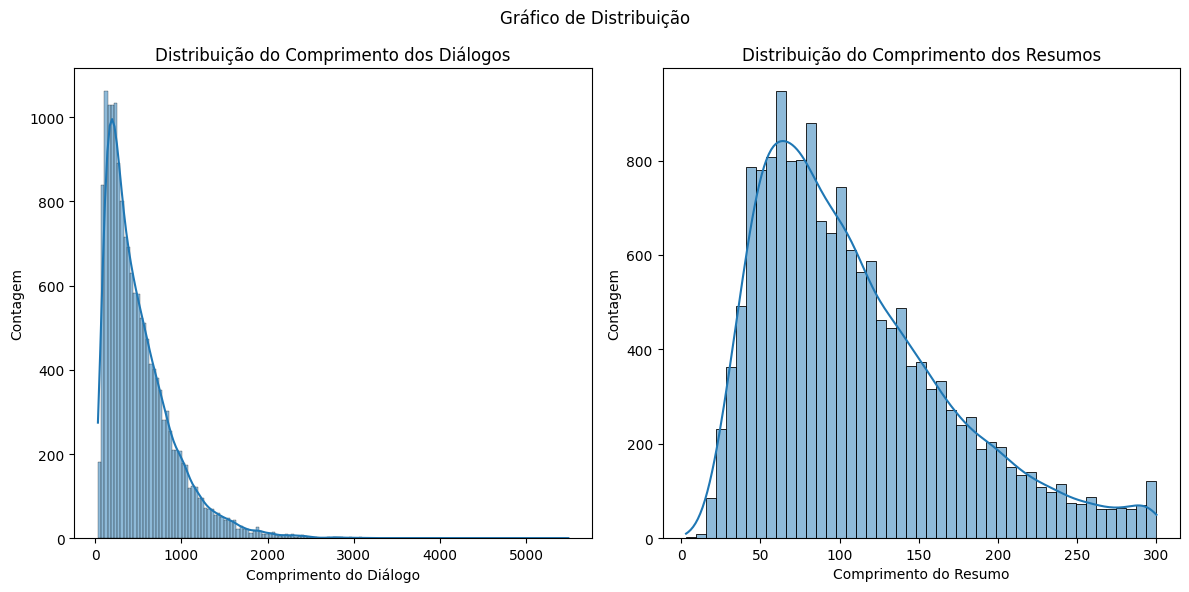

In [27]:
plt.figure(figsize=(12, 6))

# Primeiro gráfico (Distribuição do Comprimento dos Diálogos)
plt.subplot(121)
sns.histplot(df['dialogue_len'], kde=True)
plt.title('Distribuição do Comprimento dos Diálogos')
plt.xlabel('Comprimento do Diálogo')  # Rótulo do eixo X
plt.ylabel('Contagem')  # Rótulo do eixo Y

# Segundo gráfico (Distribuição do Comprimento dos Resumos)
plt.subplot(122)
sns.histplot(df['summary_len'], kde=True)
plt.title('Distribuição do Comprimento dos Resumos')
plt.xlabel('Comprimento do Resumo')  # Rótulo do eixo X
plt.ylabel('Contagem')  # Rótulo do eixo Y

# Título principal e ajuste de layout
plt.suptitle('Gráfico de Distribuição')
plt.tight_layout()
plt.show()

Grafico da Direita

Eixo X  – Número de caracteres por resumo
Vai de 0 até 300 caracteres.

Mostra o comprimento dos resumos em caracteres.

Eixo Y – Número de resumos
Vai de 0 até 900.
Indica quantos resumos estão em cada faixa de tamanho.


A maioria dos resumos tem entre 50 e 100 caracteres.

O pico está em torno de 60 a 70 caracteres (quase 900 resumos).

Depois de 100 caracteres, a quantidade de resumos cai progressivamente.

Poucos resumos passam de 200 ou 250 caracteres.





 Gráfico da Esquerda

Eixo X
Representa o número de caracteres em cada diálogo.

Eixo Y (vertical)
Mostra quantas amostras existem em cada faixa de tamanho

Mostra quantos diálogos caem em cada faixa de tamanho (ex: quantos têm entre 0–100, 100–200, etc.)



*O pico está entre 100 e 500 caracteres → mais de 1000 diálogos nessa faixa.

*Conforme o tamanho dos diálogos aumenta, o número de amostras diminui drasticamente.

*Acima de 2000 caracteres, o número de diálogos é muito pequeno (menos de 100)

*Há uma cauda longa até 5000+, típica de dados textuais.


A maior parte dos  diálogos é curta ou moderada em tamanho.

 ## Análise de Diálogos e Resumos: Frequência de Palavras Chave

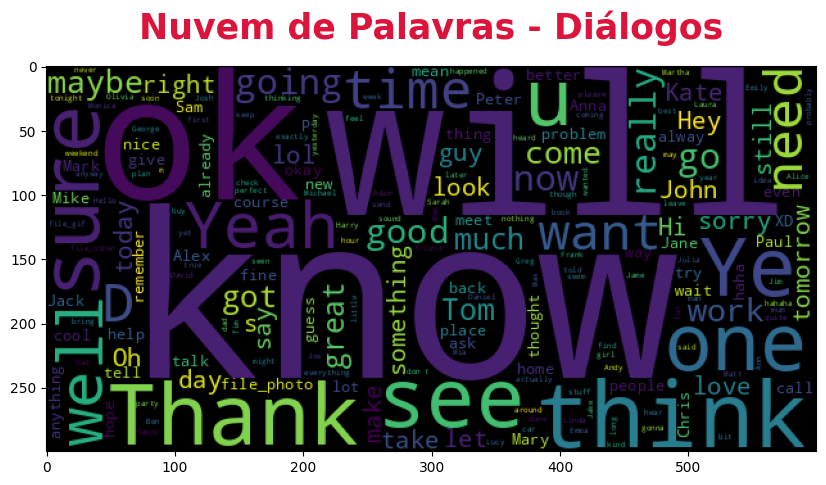

In [28]:
plt.figure(figsize=(12,5))
wc = WordCloud(width=600, height=300, random_state=42).generate(' '.join(df.dialogue))

plt.imshow(wc)
plt.title('Nuvem de Palavras - Diálogos',
          fontsize=25,
          pad=20,
          color='crimson',
          fontweight='bold')
plt.show()

Palavras maiores aparecem mais frequentemente nos diálogos.

É uma forma visual de entender quais palavras mais se repetem no  dataset.

pistas sobre temas recorrentes, por exemplo: “pedido”, “cliente”, “entrega”, “produto” etc.



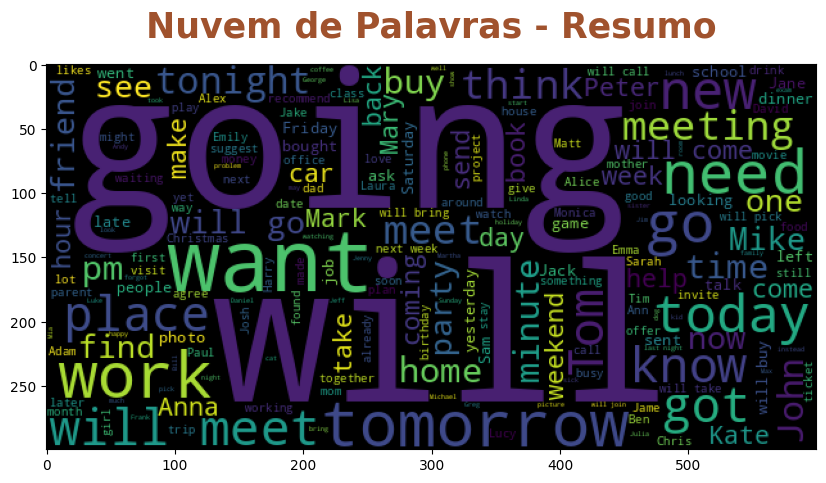

In [29]:
plt.figure(figsize=(12,5))
wc = WordCloud(width=600,height=300,random_state=42).generate(' '.join(df.summary))
plt.imshow(wc)
plt.title('Nuvem de Palavras - Resumo',fontsize=25,pad=20,color='sienna',fontweight='bold')
plt.show();

Palavras maiores = mais frequentes

Palavras menores = menos frequentes



## Análise Comparativa de Legibilidade: Diálogos vs Resumos

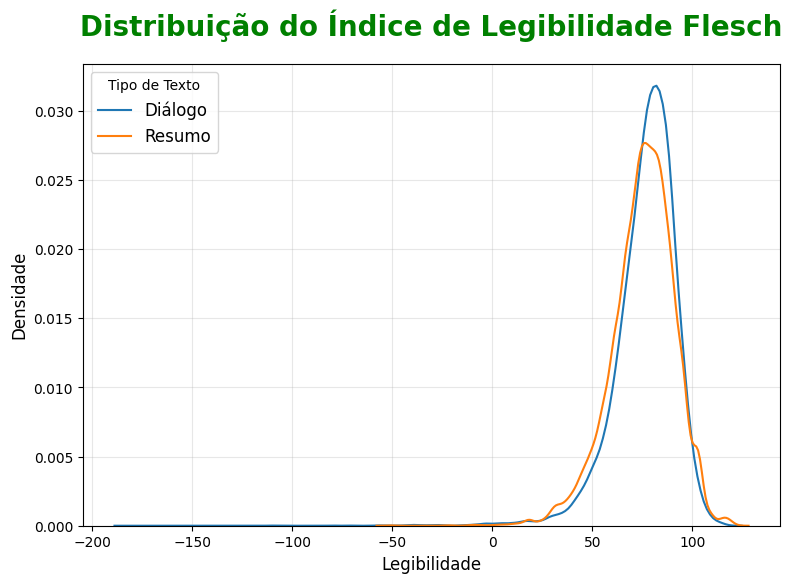

In [30]:
# Aplicar índice de legibilidade Flesch
df['dialogue_readability'] = df['dialogue'].apply(flesch_reading_ease)
df['summary_readability'] = df['summary'].apply(flesch_reading_ease)

# Plotar distribuição
plt.figure(figsize=(9,6))
sns.kdeplot(df['dialogue_readability'], label='Diálogo')
sns.kdeplot(df['summary_readability'], label='Resumo')
plt.title("Distribuição do Índice de Legibilidade Flesch",
          fontsize=20,
          pad=20,
          color='green',
          fontweight='bold')
plt.xlabel('Legibilidade', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend(title='Tipo de Texto', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

É uma métrica que avalia quão fácil é ler um texto.
Quanto maior o valor, mais fácil o texto é de entender.


Eixo X: Pontuação Flesch (facilidade de leitura/ Legibilidade).

Eixo Y: Densidade (frequência relativa).

Se a curva dos summaries estiver mais à direita do que a dos dialogues, significa que os resumos são mais fáceis de ler (o que geralmente é esperado).

Se estiverem sobrepostas, ambos têm dificuldade parecida.

## Análise da Eficiência de Compressão Textual
*Razão entre o tamanho dos diálogos e seus respectivos resumos*

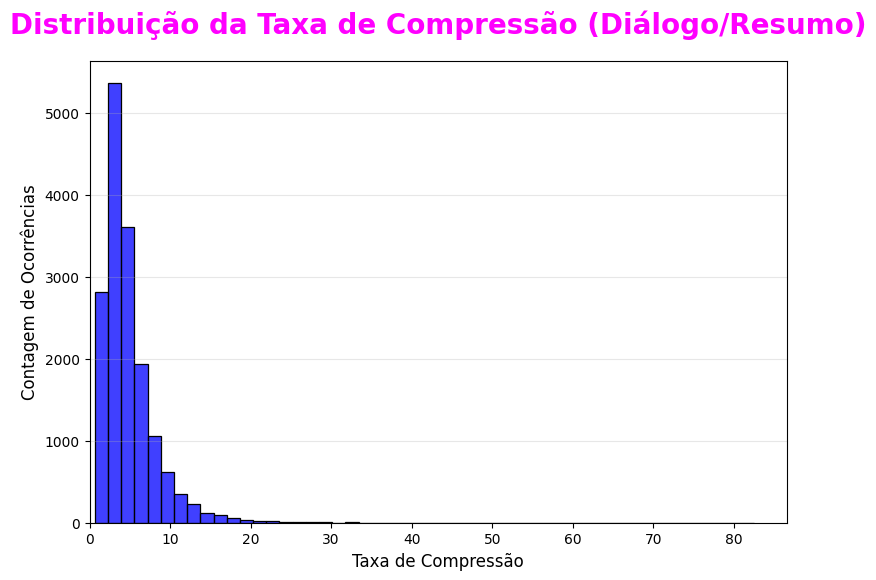

In [31]:
# Calcular taxa de compressão
df['compression_ratio'] = df['dialogue_len'] / df['summary_len']

# Plotar distribuição
plt.figure(figsize=(9,6))
sns.histplot(df['compression_ratio'], bins=50, color='blue')
plt.title("Distribuição da Taxa de Compressão (Diálogo/Resumo)",
          fontsize=20,  #
          pad=20,
          color='fuchsia',
          fontweight='bold')
plt.xlabel('Taxa de Compressão', fontsize=12)
plt.ylabel('Contagem de Ocorrências', fontsize=12)
plt.grid(axis='y', alpha=0.3)  # Grid horizontal suave
plt.xlim(left=0)  # Garantir que o eixo X comece em zero
plt.show()

##Análise de Similaridade entre Diálogos e Resumos



In [32]:
def jaccard_similarity(document,summary):     # calculando a similaridade de Jaccard entre as palavras do documento e do resumo — ou seja, ele mede quanto os dois textos têm em comum, dividindo o número de palavras iguais pelo total de palavras únicas combinadas.
    doc_content = set(document.split())
    sum_content = set(summary.split())
    return len(doc_content & sum_content) / len(doc_content | sum_content)

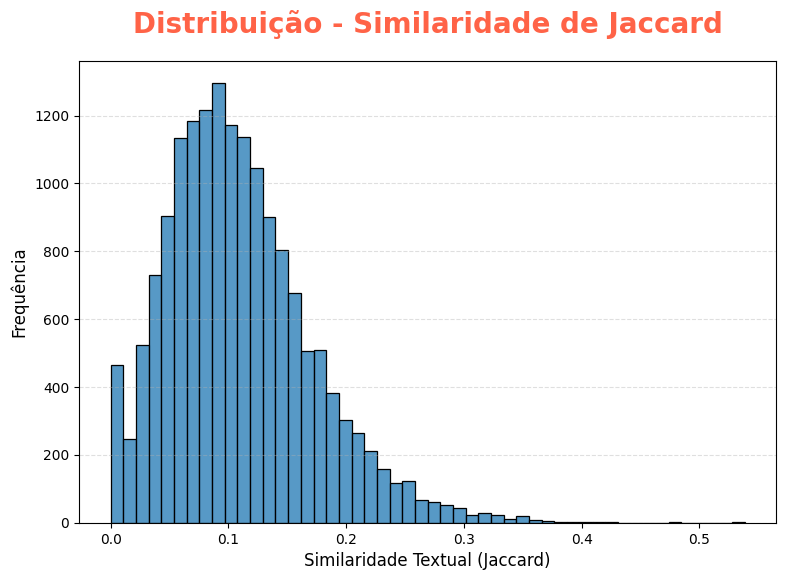

In [33]:
# Calcular similaridade de Jaccard
df['jaccard'] = df.apply(lambda x: jaccard_similarity(x['dialogue'], x['summary']), axis=1)

# Plotar distribuição
plt.figure(figsize=(9,6))
sns.histplot(df['jaccard'], bins=50)
plt.title("Distribuição - Similaridade de Jaccard",  # Título traduzido
          fontsize=20,
          pad=20,
          color='tomato',
          fontweight='bold')
plt.xlabel('Similaridade Textual (Jaccard)', fontsize=12)  # Rótulo X descritivo
plt.ylabel('Frequência', fontsize=12)  # Rótulo Y
plt.grid(axis='y', linestyle='--', alpha=0.4)  #
plt.show()

##Análise de Originalidade na Sumarização: Novidade vs Conteúdo Original
*O Índice de Novidade compara a originalidade do resumo em relação ao diálogo original,  
medindo a proporção de palavras/conceitos novos introduzidos na sumarização.*



In [34]:
def novelty_ratio(dialogue, summary):
    d = set(dialogue.split())
    s = set(summary.split())
    return len(s - d) / max(1, len(s))

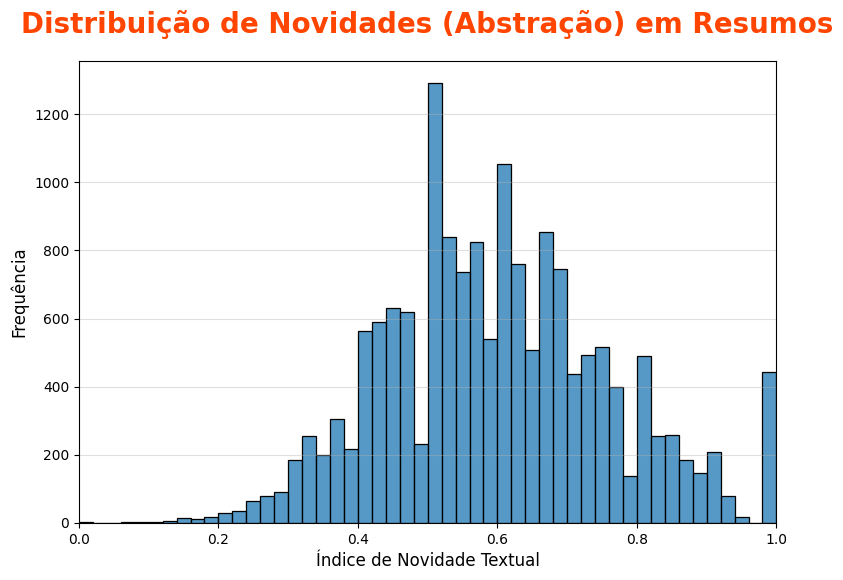

In [35]:
# Calcular métrica de novidade/abstração
df['novelty'] = df.apply(lambda x: novelty_ratio(x['dialogue'], x['summary']), axis=1)

# Plotar distribuição
plt.figure(figsize=(9,6))
sns.histplot(df['novelty'],
             bins=50)
plt.title("Distribuição de Novidades (Abstração) em Resumos",
          fontsize=20,
          pad=20,
          color='orangered',
          fontweight='bold')

plt.xlabel('Índice de Novidade Textual', fontsize=12)  # Explicando melhor a métrica
plt.ylabel('Frequência', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.4)  # Grid
plt.xlim(0, 1)  # Assumindo que é uma métrica normalizada (0-1)
plt.show()

# 5. Pré-processamento de texto

In [36]:
def lowercase_text(text):
    return text.lower()     # converte todo o texto para letras minúsculas

In [37]:
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+') # Remove URLs
    return pattern.sub(r'',text)

In [38]:
from bs4 import BeautifulSoup
def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()  # Remove tags HTML (ex: "<b>Olá</b>" → "Olá")


In [39]:
chat_words = {                                   # Dicionário para substituir automaticamente abreviações por suas formas completas.
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laughter",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "LOL": "Laughing out loud",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don’t care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "IDC": "I don’t care",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "LMAO": "Laughing my a** off",
    "BFF": "Best friends forever",
    "CSL": "Can’t stop laughing",
}

In [40]:
def chat_conversion(text):
    new_text=[]
    for w in text.split():
        if w.upper() in chat_words:
            new_text.append(chat_words[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)                                 # procura siglas/gírias de chat no texto e, se encontrar alguma, substitui pela forma completa com base no dicionário chat_words.


In [41]:
def remove_emoji(text):                              #remove todos os emojis de um texto.
    emoji_pattern = re.compile(
        "["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # símbolos e pictogramas
                           u"\U0001F680-\U0001F6FF"  # símbolos de transporte e mapa
                           u"\U0001F1E0-\U0001F1FF"  # bandeiras (iOS)
                           u"\U0001F700-\U0001F77F"  # alquimia
                           u"\U0001F780-\U0001F7FF"  # formas geométricas
                           u"\U0001F900-\U0001F9FF"  # suplementos
                           u"\U0001FA00-\U0001FA6F"  # xadrez
                           u"\U0001FA70-\U0001FAFF"  # símbolos
                           u"\U00002702-\U000027B0"  # dingbats
                           u"\U0001F800-\U0001F8FF"  # setas
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [42]:
def expand_contractions(text):                    # expande contrações da ligua inglesa
    expanded_text = contractions.fix(text)         #ex< "don't" em "do not"
    return expanded_text

In [43]:
def remove_extra_whitespace(text): #remover espaços
    return ' '.join(text.split())

In [44]:
def normalize_punctuation(text):      # retirar pontuação redundante
    text = re.sub(r'!+', '!', text)
    text = re.sub(r'\?+', '?', text)
    text = re.sub(r'\.+', '.', text)
    return text

In [45]:
def remove_special_chars(text):           # Remover símbolos não alfabéticos/númericos (exceto pontuação básica como . , ? !)
    return re.sub(r'[^a-zA-Z0-9\s.,?!]', '', text)

In [46]:
df.dialogue = df.dialogue.progress_apply(chat_conversion)
df.dialogue = df.dialogue.progress_apply(lowercase_text)
df.dialogue = df.dialogue.progress_apply(remove_url)
df.dialogue = df.dialogue.progress_apply(remove_html_tags)
df.dialogue = df.dialogue.progress_apply(remove_emoji)
df.dialogue = df.dialogue.progress_apply(expand_contractions)
df.dialogue = df.dialogue.progress_apply(remove_extra_whitespace)
df.dialogue = df.dialogue.progress_apply(normalize_punctuation)
df.dialogue = df.dialogue.progress_apply(remove_special_chars)

  0%|          | 0/16368 [00:00<?, ?it/s]

  0%|          | 0/16368 [00:00<?, ?it/s]

  0%|          | 0/16368 [00:00<?, ?it/s]

  0%|          | 0/16368 [00:00<?, ?it/s]

  0%|          | 0/16368 [00:00<?, ?it/s]

  0%|          | 0/16368 [00:00<?, ?it/s]

  0%|          | 0/16368 [00:00<?, ?it/s]

  0%|          | 0/16368 [00:00<?, ?it/s]

  0%|          | 0/16368 [00:00<?, ?it/s]

In [47]:
df.summary = df.summary.progress_apply(chat_conversion)
df.summary = df.summary.progress_apply(lowercase_text)
df.summary = df.summary.progress_apply(remove_url)
df.summary = df.summary.progress_apply(remove_html_tags)
df.summary = df.summary.progress_apply(remove_emoji)
df.summary = df.summary.progress_apply(expand_contractions)
df.summary = df.summary.progress_apply(remove_extra_whitespace)
df.summary = df.summary.progress_apply(normalize_punctuation)
df.summary = df.summary.progress_apply(remove_special_chars)

  0%|          | 0/16368 [00:00<?, ?it/s]

  0%|          | 0/16368 [00:00<?, ?it/s]

  0%|          | 0/16368 [00:00<?, ?it/s]

  0%|          | 0/16368 [00:00<?, ?it/s]

  0%|          | 0/16368 [00:00<?, ?it/s]

  0%|          | 0/16368 [00:00<?, ?it/s]

  0%|          | 0/16368 [00:00<?, ?it/s]

  0%|          | 0/16368 [00:00<?, ?it/s]

  0%|          | 0/16368 [00:00<?, ?it/s]

## Separar dados para a tokenização

In [48]:
df['summary'] = df['summary'].apply(lambda x: '<sos> ' + x.strip() + ' <eos>')   # Adiciona tokens de início/fim ao resumo


In [49]:
train_df = df[df["split"] == "train"]
val_df = df[df["split"] == "val"]
test_df = df[df["split"] == "test"]

In [50]:
print("Número de exemplos de treino:", len(train_df))
print("Diálogo vazio no treino:", train_df['dialogue'].isnull().sum())
print("Resumo vazio no treino:", train_df['summary'].isnull().sum())

Número de exemplos de treino: 14731
Diálogo vazio no treino: 0
Resumo vazio no treino: 0


In [51]:
MAX_VOCAB_SIZE = 24000

In [52]:
# Função para criar e treinar o tokenizador
def get_tokenizer(text):
    tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<UNK>") # Cria um tokenizer com limite de vocabulário
    tokenizer.fit_on_texts(text)                                         # Treina o tokenizer com os dados de texto fornecidos.
    return tokenizer

# Treinar o tokenizador apenas com o treino
tokenizer = get_tokenizer(train_df['dialogue'].tolist() + train_df['summary'].tolist())

In [53]:
def get_max_sentence_length(sentences):             # Isso determina o comprimento máximo dos diálogos e resumos.
    return max([len(line.split()) for line in sentences])

In [54]:
max_dialogue_len = get_max_sentence_length(train_df['dialogue'])
max_summary_len = get_max_sentence_length(train_df['summary'])

print("Comprimento máximo do diálogo (treino):", max_dialogue_len)
print("Comprimento máximo do resumo (treino):", max_summary_len)

Comprimento máximo do diálogo (treino): 823
Comprimento máximo do resumo (treino): 67


In [55]:
combined_vocab_size = len(tokenizer.word_index) + 1
print("Tamanho do vocabulário combinado:", combined_vocab_size)

Tamanho do vocabulário combinado: 32531


In [56]:
tokenizer.document_count

29462

In [57]:
# Aplicar tokenização
train_df['dialogue_seq'] = tokenizer.texts_to_sequences(train_df['dialogue'])
train_df['summary_seq'] = tokenizer.texts_to_sequences(train_df['summary'])

val_df['dialogue_seq'] = tokenizer.texts_to_sequences(val_df['dialogue'])
val_df['summary_seq'] = tokenizer.texts_to_sequences(val_df['summary'])

test_df['dialogue_seq'] = tokenizer.texts_to_sequences(test_df['dialogue'])
test_df['summary_seq'] = tokenizer.texts_to_sequences(test_df['summary'])

In [58]:
exemplo_idx = 0
print("\nDiálogo tokenizado (treino):")
for num in train_df['dialogue_seq'].iloc[exemplo_idx]:
    word = tokenizer.index_word.get(num, 'UNK')  # Usa o tokenizador do treino
    print(word, end=' ')


Diálogo tokenizado (treino):
amanda i baked cookies do you want some jerry sure amanda i will bring you tomorrow 

In [59]:
print("\nResumo tokenizado (treino):")
for num in train_df['summary_seq'].iloc[exemplo_idx]:
    word = tokenizer.index_word.get(num, 'UNK')
    print(word, end=' ')


Resumo tokenizado (treino):
sos amanda baked cookies and will bring jerry some tomorrow eos 

In [60]:
max_dialogue_len = 300
max_summary_len = 50

In [61]:
X_train = pad_sequences(train_df['dialogue_seq'], maxlen=max_dialogue_len, padding='post', truncating='post')
y_train = pad_sequences(train_df['summary_seq'], maxlen=max_summary_len, padding='post', truncating='post')

X_val = pad_sequences(val_df['dialogue_seq'], maxlen=max_dialogue_len, padding='post', truncating='post')
y_val = pad_sequences(val_df['summary_seq'], maxlen=max_summary_len, padding='post', truncating='post')

X_test = pad_sequences(test_df['dialogue_seq'], maxlen=max_dialogue_len, padding='post', truncating='post')
y_test = pad_sequences(test_df['summary_seq'], maxlen=max_summary_len, padding='post', truncating='post')

In [62]:
print("Formato dos dados de treino:")
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("\nFormato dos dados de validação:")
print("X_val:", X_val.shape, "| y_val:", y_val.shape)
print("\nFormato dos dados de teste:")
print("X_test:", X_test.shape, "| y_test:", y_test.shape)

Formato dos dados de treino:
X_train: (14731, 300) | y_train: (14731, 50)

Formato dos dados de validação:
X_val: (818, 300) | y_val: (818, 50)

Formato dos dados de teste:
X_test: (819, 300) | y_test: (819, 50)


#6. Treinamento do modelo

## 6.1 Preparação

In [63]:
def create_decoder_io(y_data):
    decoder_input_data = y_data[:, :-1]  # Remove último token (<eos>)
    decoder_target_data = y_data[:, 1:]  # Remove primeiro token (<sos>)
    return decoder_input_data, decoder_target_data

decoder_input_train, decoder_target_train = create_decoder_io(y_train)
decoder_input_val, decoder_target_val = create_decoder_io(y_val)
decoder_input_test, decoder_target_test = create_decoder_io(y_test)


## 6.2 Arquitetura do Modelo

In [64]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, LayerNormalization, AdditiveAttention
from tensorflow.keras import regularizers

def build_seq2seq_lstm_attention_model(src_vocab_size, dest_vocab_size, embedding_dim, units, src_timesteps, dest_timesteps):
    """
    LSTM seq2seq model with attention for text summarization.
    """
    # Encoder
    encoder_inputs = Input(shape=(src_timesteps,), name='encoder_inputs')
    encoder_embeddings = Embedding(input_dim=src_vocab_size, output_dim=embedding_dim, name='encoder_embeddings')(encoder_inputs)

    encoder_lstm = LSTM(units, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.1, name='encoder_lstm')
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embeddings)

    # Decoder
    decoder_inputs = Input(shape=(dest_timesteps,), name='decoder_inputs')
    decoder_embeddings = Embedding(input_dim=dest_vocab_size, output_dim=embedding_dim, name='decoder_embeddings')(decoder_inputs)

    decoder_lstm = LSTM(units, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2, name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_embeddings, initial_state=[state_h, state_c])

    # Attention
    attention = AdditiveAttention(name='attention_layer')
    context_vector = attention([decoder_outputs, encoder_outputs])

    # Concatenate context vector and decoder outputs
    decoder_combined_context = Concatenate(axis=-1, name='context_combined')([decoder_outputs, context_vector])
    decoder_combined_context = LayerNormalization()(decoder_combined_context)

    # Output layer
    decoder_dense = Dense(dest_vocab_size, activation='softmax')
    final_outputs = decoder_dense(decoder_combined_context)

    # Define the model
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=final_outputs)

    return model


## 6.3 Instanciação do Modelo

In [65]:
combined_vocab_size = len(tokenizer.word_index) + 1

model = build_seq2seq_lstm_attention_model(
    src_vocab_size=combined_vocab_size,
    dest_vocab_size=combined_vocab_size,
    src_timesteps=max_dialogue_len,
    embedding_dim=300,
    units=64,
    dest_timesteps=max_summary_len
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embeddings  │ (None, 300, 300)  │  9,759,300 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embeddings  │ (None, 50, 300)   │  9,759,300 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 300, 64), │     93,440 │ encoder_embeddin… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 50, 64),  │     93,440 │ decoder_embeddin… │
│                     │ (None, 64),       │            │ encoder_lstm[0][… │
│                     │ (None, 64)]       │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 50, 64)    │         64 │ decoder_lstm[0][… │
│ (AdditiveAttention) │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_combined    │ (None, 50, 128)   │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 50, 128)   │        256 │ context_combined… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50, 32531) │  4,196,499 │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,902,299 (91.18 MB)

 Trainable params: 23,902,299 (91.18 MB)

 Non-trainable params: 0 (0.00 B)

## 6.4 Plotar

In [66]:
from tensorflow.keras.utils import plot_model

# Geração do diagrama do modelo
plot_model(
    model,
    to_file='model_architecture.png',  # Nome do arquivo de saída
    show_shapes=True,
    show_layer_names=True,
    dpi=100,
    rankdir='TB',  # Orientação: TB (top to bottom), LR (left to right)
    expand_nested=True  # Mostra camadas aninhadas
)

print("Diagrama do modelo salvo em 'model_architecture.png'")

Diagrama do modelo salvo em 'model_architecture.png'


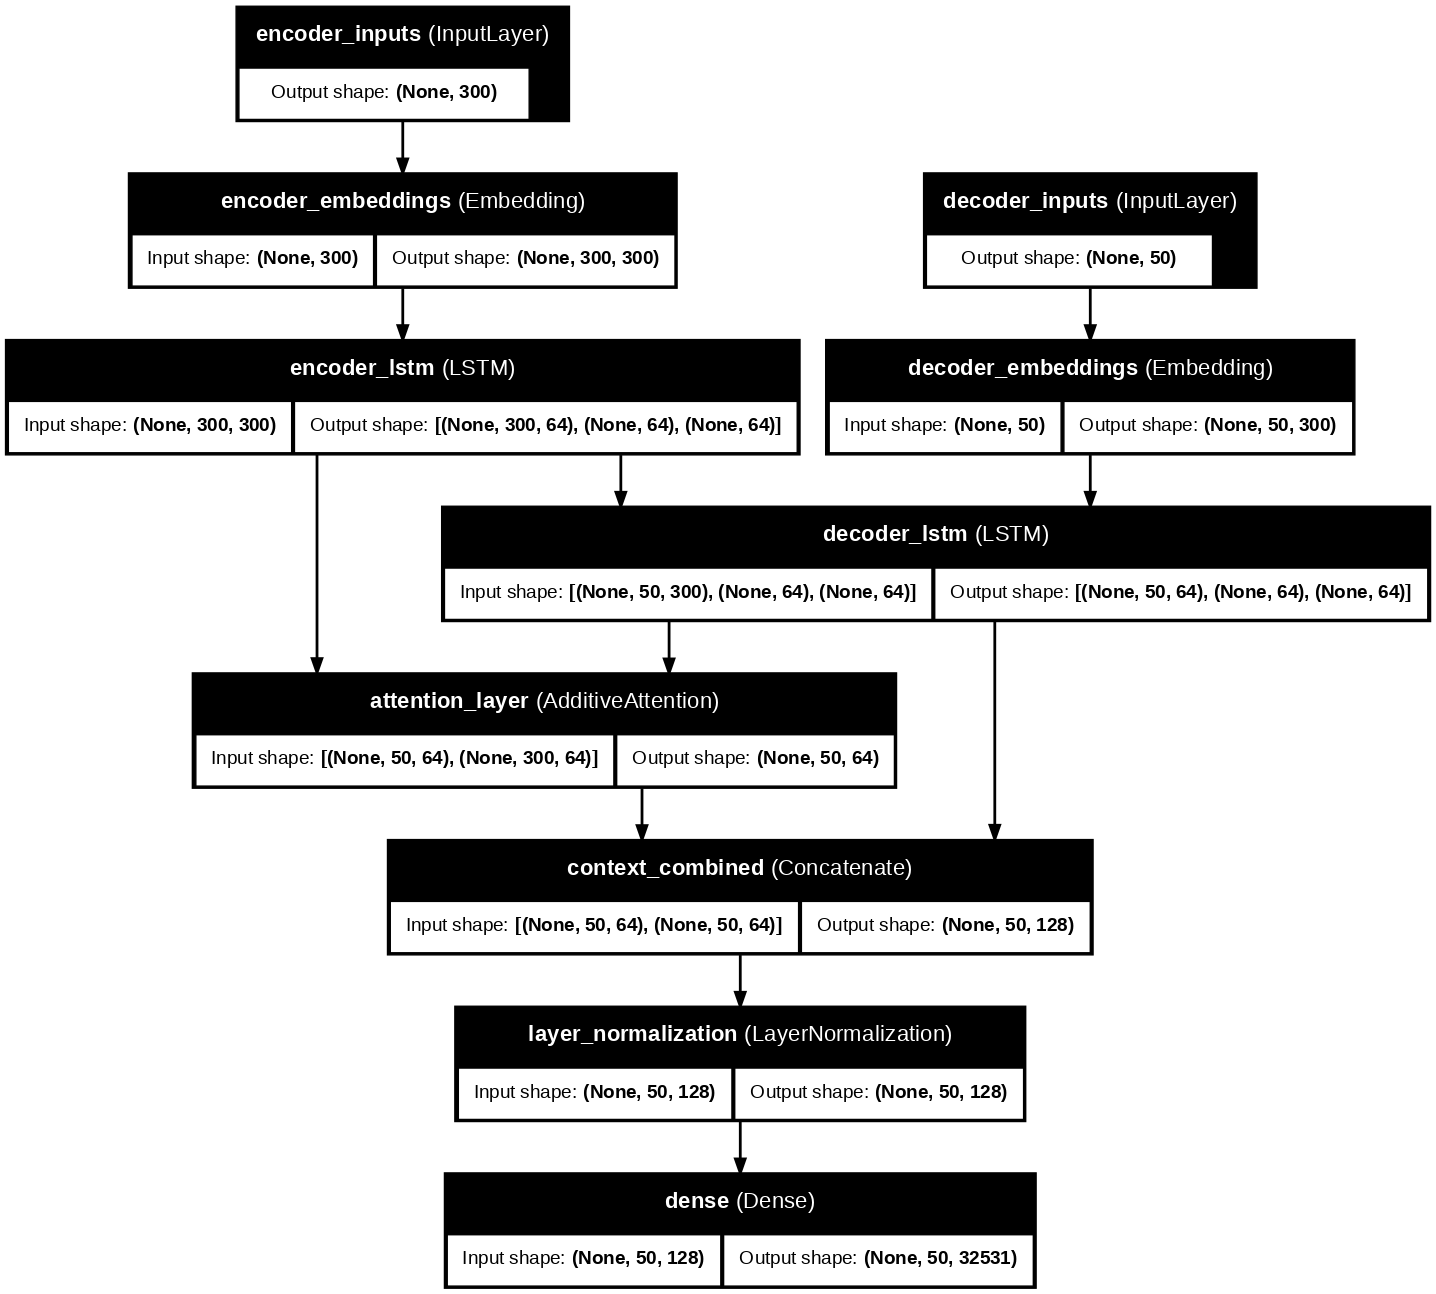

In [67]:
plot_model(model,'model_architecture.png',dpi=100,show_shapes=True,show_layer_names=True)

## 6.5 Compilação e Callbacks


In [68]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1,
        start_from_epoch=3
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        min_lr=1e-6,
        mode='min',
        verbose=1
    ),
     TensorBoard(
         log_dir='./',
         histogram_freq=1,
         write_graph=True,
         update_freq='epoch',
         embeddings_freq=1),
    ModelCheckpoint(
        filepath='best_summarizer.keras',
        save_best_only=True,
        monitor='val_loss',
        verbose=1,
        mode='min',
        save_freq='epoch'
    )
]


## 6.6 Treinamento do modelo

In [69]:
modelo = model.fit(
    [X_train,y_train],
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=([X_test,y_test],y_test),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5563 - loss: 5.3086
Epoch 1: val_loss improved from inf to 1.31763, saving model to best_summarizer.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.5568 - loss: 5.2997 - val_accuracy: 0.8400 - val_loss: 1.3176 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8649 - loss: 1.1376
Epoch 2: val_loss improved from 1.31763 to 0.52079, saving model to best_summarizer.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - accuracy: 0.8650 - loss: 1.1367 - val_accuracy: 0.9413 - val_loss: 0.5208 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9456 - loss: 0.4796
Epoch 3: val_loss improved from 0.52079 to 0.27518, saving model to best_summarizer.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.9456 - loss: 0.4794 - val_accuracy: 0.9711 - val_loss: 0.2752 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - 

## Avaliação

In [70]:
test_loss, test_acc = model.evaluate(
    [X_test, decoder_input_test],
    decoder_target_test,
    verbose=0
)

print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')


Test Loss: 7.1660
Test Accuracy: 0.5459


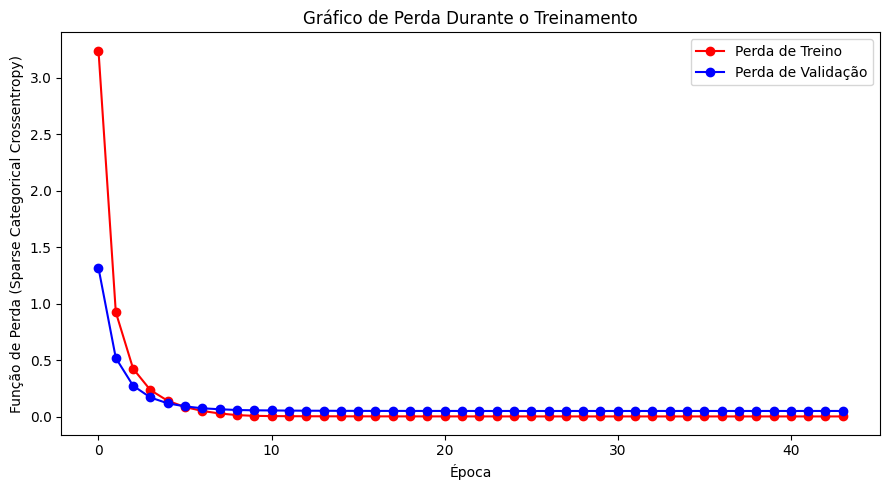

In [71]:
plt.figure(figsize=(9,5))
plt.plot(modelo.history['loss'], 'r', label='Perda de Treino', marker='o')
plt.plot(modelo.history['val_loss'], 'b', label='Perda de Validação', marker='o')
plt.xlabel('Época')
plt.ylabel('Função de Perda (Sparse Categorical Crossentropy)')
plt.title('Gráfico de Perda Durante o Treinamento')
plt.legend()
plt.tight_layout()
plt.show()

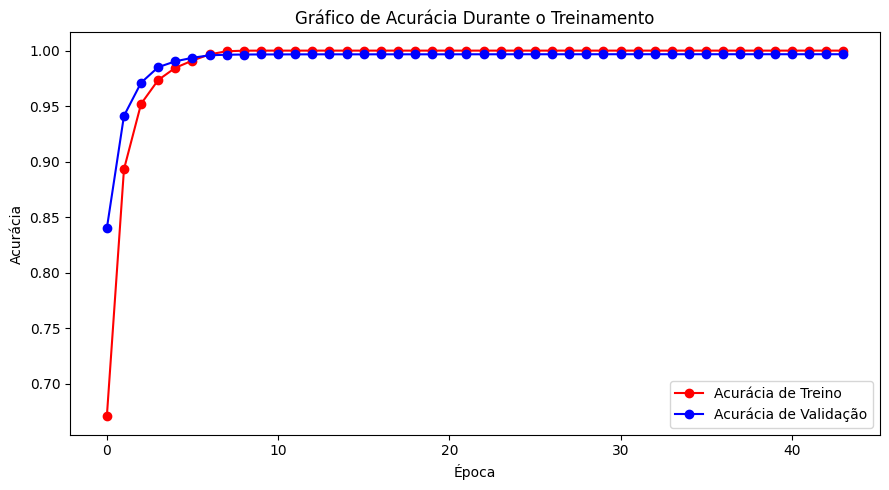

In [77]:
plt.figure(figsize=(9,5))
plt.plot(modelo.history['accuracy'], 'r', label='Acurácia de Treino', marker='o')
plt.plot(modelo.history['val_accuracy'], 'b', label='Acurácia de Validação', marker='o')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Gráfico de Acurácia Durante o Treinamento')
plt.legend()
plt.tight_layout()
plt.show()

In [83]:
def summarize_model_predictions(model, tokenizer, X_test, y_test, numero_amostras=10):
    """
    Exibe resumos previstos versus reais para algumas amostras de teste.

    Parâmetros:
    - modelo: Modelo seq2seq treinado
    - tokenizador: Tokenizador usado para entrada e saída
    - X_teste: Diálogos de entrada padronizados
    - y_teste: Resumos de saída padronizados
    - numero_amostras: Número de exemplos para exibir
    """
    indice_para_palavra = {indice: palavra for palavra, indice in tokenizer.word_index.items()}
    indice_sos = tokenizer.word_index.get('sos')
    indice_eos = tokenizer.word_index.get('eos')

    subconjunto_X = X_test[:numero_amostras]
    subconjunto_y = y_test[:numero_amostras]

    # Prever probabilidades dos tokens
    previsoes = model.predict([subconjunto_X, subconjunto_y], verbose=0, batch_size=64)
    ids_tokens_previstos = np.argmax(previsoes, axis=-1)

    frases_previstas = []
    resumos_reais = []
    dialogos = []

    for i in range(numero_amostras):
        # Converter IDs de tokens previstos para palavras
        frase_prevista = ' '.join([
            indice_para_palavra.get(tok, '<unk>')
            for tok in ids_tokens_previstos[i]
            if tok != 0 and tok != indice_sos and tok != indice_eos
        ])
        frases_previstas.append(frase_prevista)

        # Converter IDs de tokens reais para palavras
        frase_real = ' '.join([
            indice_para_palavra.get(tok, '<unk>')
            for tok in subconjunto_y[i]
            if tok != 0 and tok != indice_sos and tok != indice_eos
        ])
        resumos_reais.append(frase_real)

        # Converter diálogo de entrada para palavras
        dialogo_entrada = ' '.join([
            indice_para_palavra.get(tok, '<unk>')
            for tok in subconjunto_X[i]
            if tok != 0
        ])
        dialogos.append(dialogo_entrada)

    # Exibir resultados
    for i in range(numero_amostras):
        print(f"\n🗣️ Diálogos {i+1}:\n{dialogos[i]}")
        print(f"\n✅ Resumo real:\n{resumos_reais[i]}")
        print(f"\n🔁 Predição:\n{frases_previstas[i]}")
        print("-" * 100)

summarize_model_predictions(model, tokenizer, X_test, y_test, numero_amostras=10)


🗣️ Diálogos 1:
hannah hey do you have bettys number amanda let me check hannah amanda sorry cannot find it amanda ask larry amanda he called her last tears in my eyes we were at the park together hannah i do not know him well hannah amanda do not be shy he is very nice hannah if you say so hannah i would rather you texted him amanda just text him hannah urgh alright hannah bye amanda bye bye

✅ Resumo real:
hannah needs bettys number but amanda does not have it she needs to contact larry

🔁 Predição:
hannah needs bettys number but amanda does not have it she needs to contact larry
----------------------------------------------------------------------------------------------------

🗣️ Diálogos 2:
eric machine rob that is so gr8 eric i know and shows how americans see russian rob and it is really funny eric i know i especially like the train part rob hahaha no one talks to the machine like that eric is this his only standup rob i do not know i will check eric sure rob turns out no there

In [87]:
dicionario_reverso_resumo = {indice: palavra for palavra, indice in tokenizer.word_index.items()}
dicionario_reverso_dialogo = {indice: palavra for palavra, indice in tokenizer.word_index.items()}

tamanho_batch = 16

resumos_previstos = []
resumos_referencia = []

# Previsões nos dados de teste em lotes
for inicio in range(0, len(X_test), tamanho_batch):
    fim = min(inicio + tamanho_batch, len(X_test))
    X_batch = X_test[inicio:fim]
    y_batch = y_test[inicio:fim]

    # Previsão no lote
    previsoes = model.predict([X_batch, y_batch], batch_size=tamanho_batch, verbose=0)

    # Converter tokens previstos em frases
    tokens_previstos = np.argmax(previsoes, axis=-1)

    for lista_tokens in tokens_previstos:
        resumo_previsto = ' '.join([
            dicionario_reverso_resumo.get(token, '<desconhecido>')
            for token in lista_tokens
            if token != 0 and token not in [tokenizer.word_index.get('sos'), tokenizer.word_index.get('eos')]
        ])
        resumos_previstos.append(resumo_previsto)

    for i in range(len(y_batch)):
        resumo_original = ' '.join([
            dicionario_reverso_resumo.get(token, '<desconhecido>')
            for token in y_batch[i]
            if token != 0 and token not in [tokenizer.word_index.get('sos'), tokenizer.word_index.get('eos')]
        ])
        resumos_referencia.append([resumo_original.split()])

In [88]:
# Avaliar pontuação BLEU
pontuacao_bleu = corpus_bleu(resumos_referencia, [resumo.split() for resumo in resumos_previstos])
print(f'BLEU score: {pontuacao_bleu:.4f}')

BLEU score: 0.9805


In [89]:
def avaliar_pontuacoes_rouge(resumos_previstos, resumos_referencia):
    """
    Avalia as métricas ROUGE-1, ROUGE-2 e ROUGE-L para os resumos gerados.

    Parâmetros:
    - resumos_previstos: lista de strings com resumos previstos
    - resumos_referencia: lista de listas com resumos de referência

    Retorna:
    - Dicionário com as médias das pontuações ROUGE
    """
    avaliador = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    pontuacoes_rouge1 = []
    pontuacoes_rouge2 = []
    pontuacoes_rougeL = []

    for previsto, referencia in zip(resumos_previstos, resumos_referencia):
        ref = ' '.join(referencia[0])  # Única referência por previsão
        metricas = avaliador.score(ref, previsto)

        pontuacoes_rouge1.append(metricas['rouge1'].fmeasure)
        pontuacoes_rouge2.append(metricas['rouge2'].fmeasure)
        pontuacoes_rougeL.append(metricas['rougeL'].fmeasure)

    return {
        'ROUGE-1': np.mean(pontuacoes_rouge1),
        'ROUGE-2': np.mean(pontuacoes_rouge2),
        'ROUGE-L': np.mean(pontuacoes_rougeL)
    }

resultados_rouge = avaliar_pontuacoes_rouge(resumos_previstos, resumos_referencia)

In [90]:
print("\n📊 ROUGE Scores:")
for metrica, pontuacao in resultados_rouge.items():
    print(f"{metrica}: {pontuacao:.4f}")


📊 ROUGE Scores:
ROUGE-1: 0.9917
ROUGE-2: 0.9842
ROUGE-L: 0.9917
